In [1]:
import cv2
import os
import shutil
import pickle
import numpy as np
from matplotlib import pyplot as plt

def plt_rgb(img):
    b,g,r = cv2.split(img)
    img = cv2.merge([r, g, b])
    plt.imshow(img)
    plt.show()

Read_imgPath = './full_car/t23.png'
Write_imgPath = './Recognition/'
Pic_differ ='_1.png'

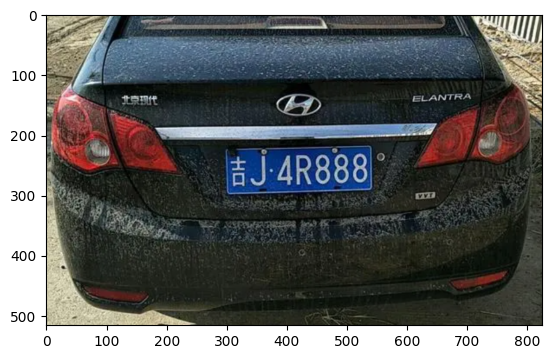

In [2]:
org_image = cv2.imread(Read_imgPath)
plt_rgb(org_image)

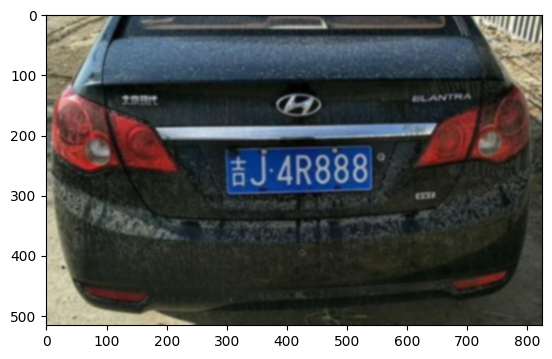

In [3]:
# Gaussian blurring is used to remove noise while retaining key components and edge information, serving as a precursor for edge extraction. 
# A (3,3) Gaussian kernel size is used, where a larger kernel results in more blurring, and the kernel size must be an odd number. 
#Setting the standard deviation to 0 allows OpenCV to automatically configure it.
blur_image = cv2.GaussianBlur(org_image, (9, 9), 0)
plt_rgb(blur_image)

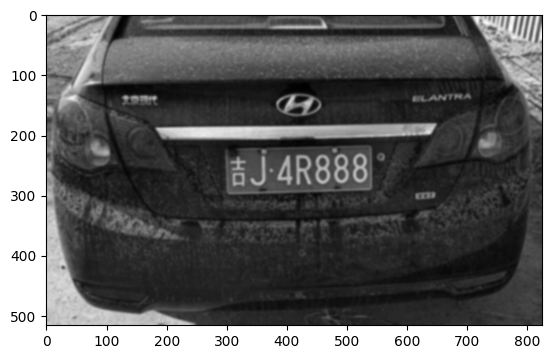

In [4]:
# Grayscale
gray_image = cv2.cvtColor(blur_image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, cmap='gray')

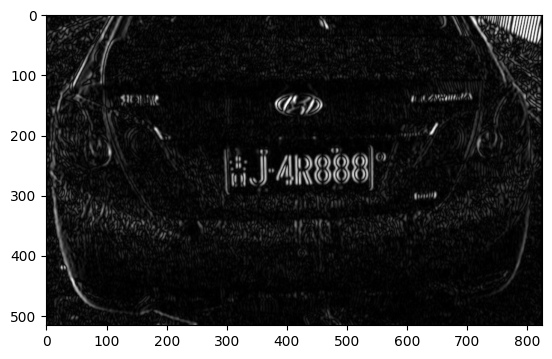

In [5]:
# 16S refers to converting to the int16 data type, as the calculations may involve negative values. 
# (1,0) indicates the horizontal direction, while (0,1) represents the vertical (y) direction.
sobel_X = cv2.Sobel(gray_image, cv2.CV_16S, 1, 0)
#sobel_Y = cv2.Sobel(gray_image, cv2.CV_16S, 0, 1)

single_X = cv2.convertScaleAbs(sobel_X)  # Convert back to unsigned uint8 format to display the image
#single_Y = cv2.convertScaleAbs(sobel_y)

#combo = cv2.addWeighted(single_X, 0.5, single_Y, 0.5, 0)
#sobel_image = combo
sobel_image = single_X
plt.imshow(sobel_image, cmap='gray')

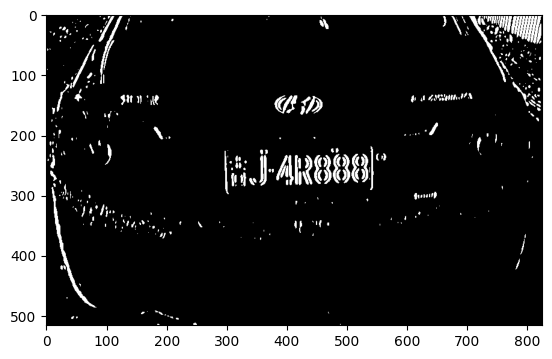

In [6]:
# Binary processing: 0 represents automatic threshold calculation, 255 means that values exceeding the threshold are set to 255, otherwise set to 0. 
#cv2.THRESH_OTSU is a flag for global threshold calculation.
# ret returns the computed optimal threshold value, and image returns the binarized image.
ret, bi_image = cv2.threshold(sobel_image, 0, 255, cv2.THRESH_OTSU)
plt.imshow(bi_image, cmap='gray')

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


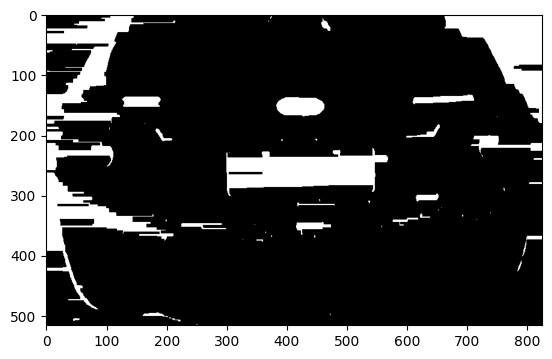

In [7]:
# Morphological closing operation connects adjacent white regions into a single entity and fills holes, preparing for the extraction of the entire license plate.
# cv2.getStructuringElement is used for morphological operations to generate a structuring rectangle, which determines the extent of filling. 
# The larger the value, the larger the filled area.
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 2))
print(kernelX)

# Perform morphological closing operation.
closed_image = cv2.morphologyEx(bi_image, cv2.MORPH_CLOSE, kernelX,iterations = 3)
plt.imshow(closed_image, cmap='gray')

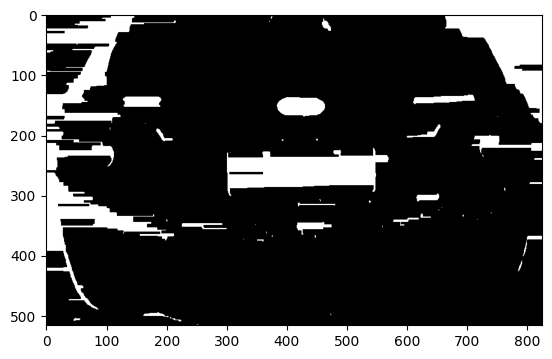

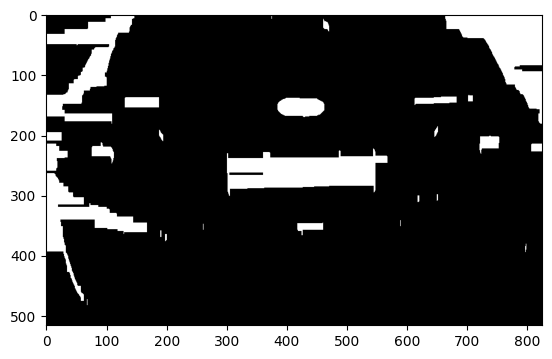

In [8]:
# Erosion occurs when any black pixel is present within the structuring element's coverage of the foreground, causing the entire area to erode into the background. 
# Dilation, on the other hand, fills the entire area with white if any white pixel is present within the coverage.
# This process helps remove small white spots.
kernel_axis_X = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
kernel_axis_Y = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))

# Dilation, erosion, and closing operations are used to connect small breaks in the horizontal direction.
dil_image_X = cv2.dilate(closed_image, kernel_axis_X)
ero_image_X = cv2.erode(dil_image_X, kernel_axis_X)
plt.figure()
plt.imshow(ero_image_X, cmap='gray')

# Erosion, dilation, and opening operations are used to eliminate small noise in the vertical direction.
ero_image_Y = cv2.erode(ero_image_X, kernel_axis_Y)
dil_image_Y = cv2.dilate(ero_image_Y, kernel_axis_Y)
plt.figure()
plt.imshow(dil_image_Y, cmap='gray')

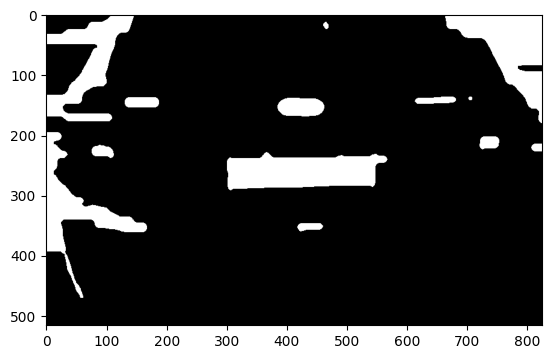

In [9]:
# Median filtering transforms each pixel's value into the median of its own value and the values of neighboring pixels, effectively reducing unnecessary noise.
# 15 represents the size of the filtering region; the larger the value, the stronger the effect, but it may also remove parts that should be retained. 
# The size must be an odd number, as only an odd-sized window has a middle value, which is not possible with a 2x2 window.
median_image = cv2.medianBlur(dil_image_Y, 11)
plt.imshow(median_image, cmap='gray')

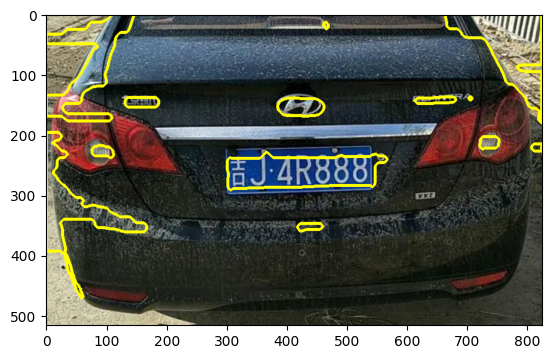

In [10]:
# Contour detection: cv2.RETR_EXTERNAL is used to detect only the external contours. 
# cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal elements, keeping only the end points in those directions. 
# For example, a rectangular contour only requires four points to store its contour information. 
# contours returns a set of contour coordinates, while hierarchy returns the parent-child relationship of contours, which is not important.
contours, hierarchy = cv2.findContours(median_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Contour display: -1 indicates that all contours will be drawn, (0,255,0) specifies the color of the lines, and 5 represents the line width.
draw_image = org_image.copy()
cv2.drawContours(draw_image, contours, -1, (0, 255, 255), 4)
plt_rgb(draw_image)

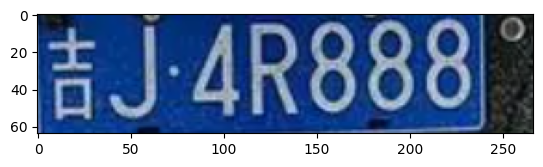

car plate found


In [11]:
# contours filtering
for item in contours:
    # cv2.boundingRect uses the smallest rectangle to cover the contour, 
    # where xy represents the coordinates of the top-left corner, and wh represents the width and height.
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    width  = rect[2]
    height = rect[3]
    
    if (width > (height * 2.5)) and (width < (height * 5)) and width >= 100:
        car_plate = org_image[y:y + height, x:x + width]
        plt.figure()
        plt_rgb(car_plate)
        cv2.imwrite('./car_license/test4.png', car_plate)
        break
print("car plate found")

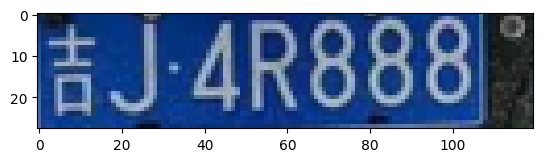

In [12]:
# resize with original ratio
width = 120
height = None

(h, w) = car_plate.shape[:2]
if width is not None:
    asp_ratio = width / float(w)
    di_re = (width, int(h * asp_ratio))
    
elif height is not None:
    asp_ratio = height / float(h)
    di_re = (int(w * asp_ratio), height)

car_plate = cv2.resize(car_plate, di_re, interpolation=cv2.INTER_AREA)
plt_rgb(car_plate)

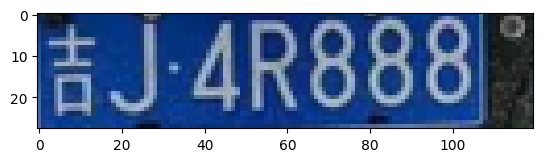

In [13]:
# Blur
blur_car_plate = cv2.GaussianBlur(car_plate, (1, 1), 0)
plt_rgb(blur_car_plate)

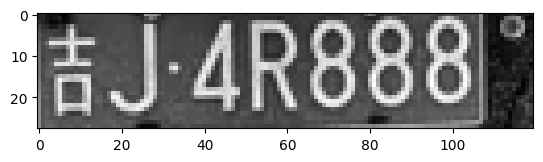

In [14]:
# grayscale
gray_car_plate = cv2.cvtColor(blur_car_plate, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_car_plate, cmap='gray')

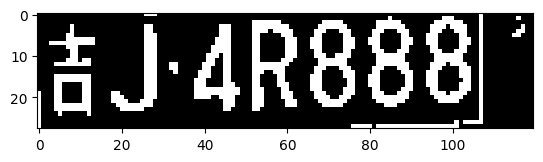

In [15]:
# Binarisation
ret, bi_car_plate = cv2.threshold(gray_car_plate, 0, 255, cv2.THRESH_OTSU)
plt.imshow(bi_car_plate, cmap='gray')

In [16]:
# deal with different colors of plates, keep it white chars with blackgound
white_counter = 0
black_counter = 0
height, width = bi_car_plate.shape
# print(bi_car_plate.shape)
for i in range(height):
    for j in range(width):
        if bi_car_plate[i, j] == 255:
            white_counter += 1
        else:
            black_counter += 1
if white_counter > black_counter:
    ret, bi_car_plate = cv2.threshold(bi_car_plate, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    plt.imshow(bi_car_plate, cmap='gray')
else:
    print('no need to convert the plate')

no need to convert the plate


In [17]:
# check pixel information
bi_car_plate.shape 
rows = bi_car_plate.shape[0]
cols = bi_car_plate.shape[1]
print(rows,cols)

28 120


In [18]:
# accumulate
row_white = []
for row in range(rows):
    row_white_counter = 0
    for col in range(cols):
        if bi_car_plate[row][col] == 255: #白色像素值为255
            row_white_counter = row_white_counter + 1
    row_white.append(row_white_counter)
len(row_white)
max(row_white)

52

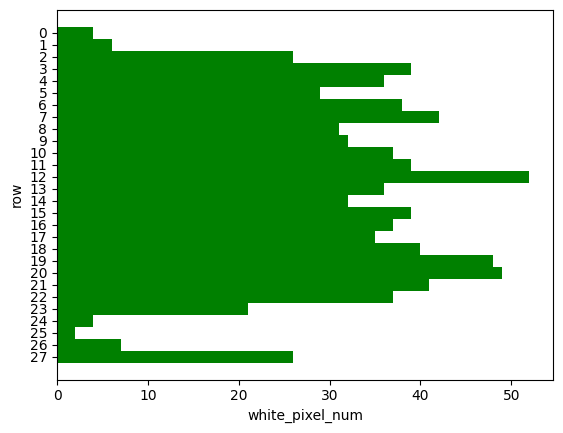

In [19]:
# Draw a horizontal histogram.
y = [y for y in range(rows)]
x = row_white
plt.barh(y,x,color='green',height=1)

plt.xlabel('white_pixel_num')
plt.ylabel('row')

# change the direction of y axis for better vision
plt.xticks([x for x in range(0,max(row_white)+5,10)])
plt.yticks([y for y in range(0,rows,1)])
plt.gca().invert_yaxis()

plt.show()

In [20]:
# Locate the midpoint, as license plates typically contain 7 to 10 characters. 
# This implies that each row must have at least one pixel for it to be part of the license plate area. 
# Such testing has been proven effective in most cases.
middle_row = len(row_white) // 2  
boundary = []

# scanning upwards
for i in range(middle_row, -1, -1):
    if i >0:
     if row_white[i] < 11:  
         boundary.append(i)  
         break
    else:
        boundary.append(i)

# scanning downwards
found = False  
for i in range(middle_row, len(row_white)): 
    if row_white[i] < 11:
        print(i)
        boundary.append(i)  
        found = True  
        break

# use the last one as the boundary if no findings
if not found:
    boundary.append(len(row_white))
print(boundary)


24
[1, 24]


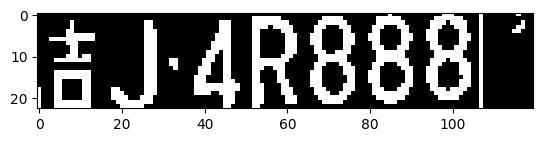

In [21]:
# cut the top and bottom
bi_car_plate = bi_car_plate[boundary[0]:boundary[1],:] 
plt.imshow(bi_car_plate, cmap='gray')

In [22]:
# update information
rows = bi_car_plate.shape[0]
cols = bi_car_plate.shape[1]

In [23]:
col_white = []
for col in range(cols):
    col_white_counter = 0
    for row in range(rows):
        if bi_car_plate[row][col] == 255: 
            col_white_counter = col_white_counter + 1
    col_white.append(col_white_counter)
len(col_white)

120

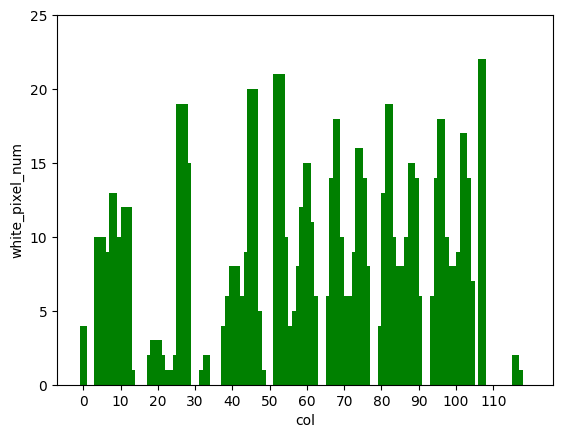

In [24]:
# Draw a vertical histogram.
x = [x for x in range(cols)]
#y = col_white
col_white = [max(value - 1, 0) for value in col_white]
y = col_white

plt.bar(x,y,color='green', width=2)
plt.xlabel('col')
plt.ylabel('white_pixel_num')
plt.xticks([x for x in range(0,cols,10)])
plt.yticks([y for y in range(0,max(col_white)+5,5)])

plt.show()

In [25]:
# filter
start_detection = False  
position_record = [] 
boundary_col = []  

for i in range(cols-1):
    
    if not start_detection and col_white[i] == 0:
        start_detection = True  

 
    if start_detection:
        if col_white[i] == 0 and col_white[i+1] != 0:
            position_record.append(i)
        if col_white[i] != 0 and col_white[i+1] == 0:
            position_record.append(i+2)

        if len(position_record) == 2:
            if (position_record[1] - position_record[0]) >= 7:  
                boundary_col.append(position_record)
                position_record = []  
            else:
                position_record = []  

In [26]:
# clear files
for filename in os.listdir(Write_imgPath):
    file_path = os.path.join(Write_imgPath, filename)
    
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  
    except Exception as e:
        print(f"error {file_path}。reason: {e}")

print(f"{Write_imgPath} clear!")

./Recognition/ clear!


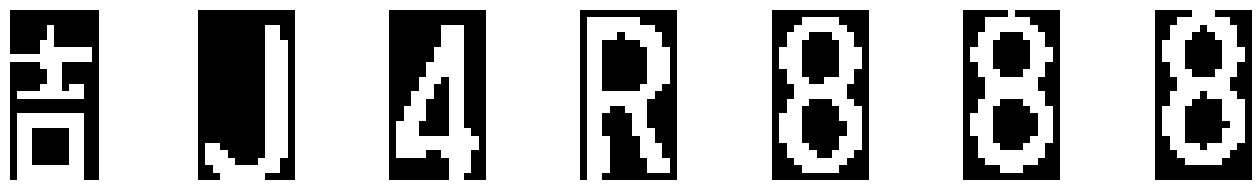

In [27]:
# segmentation
plate_chars = []
i = 1
num_chars = len(boundary_col)  
plt.figure(figsize=(num_chars * 2, 2))

for idx, m in enumerate(boundary_col):
    char_img = bi_car_plate[:, m[0]:m[1]]
    
    plt.subplot(1, num_chars, idx + 1)
    plt.imshow(char_img, cmap='gray')
    plt.axis('off')  
    
    plate_chars.append(char_img)
    
    cv2.imwrite(Write_imgPath + str(i) + Pic_differ, char_img)
    i += 1


plt.tight_layout()
# show all character
plt.show()

In [28]:
# load model

with open('TM.pkl', 'rb') as f:
    tm = pickle.load(f)

In [29]:
#load dictionary
chars = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','J','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z',
    '藏','川','鄂','甘','赣','贵','桂','黑','沪','吉','冀','津','晋','京','辽','鲁','蒙','闽','宁',
    '青','琼','陕','苏','皖','湘','新','渝','豫','粤','云','浙'
]


chars_mapping = {char: idx for idx, char in enumerate(chars)}
inverse_chars_mapping = {idx: char for char, idx in chars_mapping.items()}


plate_number = ""
image_files = sorted(os.listdir(Write_imgPath))  

for image_file in image_files:
    
    image_path = os.path.join(Write_imgPath, image_file)
    
    char_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    sample_image = cv2.resize(char_img, (28, 28))  
    sample_image = np.where(sample_image >= 75, 1, 0)


    # use model
    predicted_label = tm.predict(sample_image)  
    predicted_char = inverse_chars_mapping[predicted_label[0]] # encoded labels to real chars
    
    # predict chars
    plate_number += predicted_char

# Car plate output
print(f"car license: {plate_number}")

car license: 吉J4R888
